# xgboost regressor experience

### library settting

In [1]:
import os
import datetime
from xgboost import XGBRegressor
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

### data loading

In [11]:
# train_x와 train_y merging한 파일
df = pd.read_hdf('./data/merged_data.h5')

# 임의로 sample_id 1000까지는 train으로 이후는 test로 구분지어 둠.
train_df = df[df.sample_id <= 1000]
test_df = df[df.sample_id > 1000]

# window size 지정
n_steps = 60

In [12]:
#앞부분이 필요가 없을 것 같아서 다시 피팅
train_df = train_df[train_df.time > (1500 - 121 - n_steps)]

### data preprocessing 
open 데이터를 지정한 window 만큼 보고 다음 값을 예측
window pararmeter : n_step

In [13]:
def split_sequence(dataframe, n_steps = n_steps):

    ''' 설명 생략 '''

    # grouping
    grouped_df = dataframe.groupby('sample_id')
    
    # export unique sample ids
    unique_sample_id_list = grouped_df.sample_id.unique()

    # create new lists
    X, y = list(), list()

    # get one group & split sequence
    for sample_id in unique_sample_id_list:
        
        # get one sample_id in sample list
        temp_sample_id = sample_id.item()

        # get one group by temp_sample_id
        temp_df = grouped_df.get_group(temp_sample_id)

        # get open price series in selected group
        temp_series = temp_df.open.values

        # in one dataframe loop
        for idx in range(len(temp_series)):

            # find the end of this pattern
            end_idx = idx + n_steps

            # check if we are beyond the sequence
            if end_idx > len(temp_series)-1:
                break

            # gather input and output parts of the pattern
            seq_x, seq_y = temp_series[idx:end_idx], temp_series[end_idx]

            X.append(seq_x)
            y.append(seq_y)
    
    
    # creat new dataframe
    col_list = list()

    for i in range(n_steps, 0,-1):
        name = f'x-{i}'
        col_list.append(name)
    
    new_df = pd.DataFrame(X, columns = col_list)
    new_df['y'] = y
    
    return new_df

In [14]:
preprocessed_train_df = split_sequence(dataframe = train_df, n_steps = n_steps)

In [15]:
# 전처리 예시
preprocessed_train_df

,x-60,x-59,x-58,x-57,x-56,x-55,x-54,x-53,x-52,x-51,...,x-9,x-8,x-7,x-6,x-5,x-4,x-3,x-2,x-1,y
0,0.997657,0.997166,0.997044,0.996699,0.996699,0.997658,0.997784,0.997168,0.997669,0.997742,...,0.999019,0.999389,0.999138,0.999617,0.999015,0.998400,0.999018,0.999629,1.000000,0.999389
1,0.997166,0.997044,0.996699,0.996699,0.997658,0.997784,0.997168,0.997669,0.997742,0.997740,...,0.999389,0.999138,0.999617,0.999015,0.998400,0.999018,0.999629,1.000000,0.999389,0.999593
2,0.997044,0.996699,0.996699,0.997658,0.997784,0.997168,0.997669,0.997742,0.997740,0.997747,...,0.999138,0.999617,0.999015,0.998400,0.999018,0.999629,1.000000,0.999389,0.999593,0.999266
3,0.996699,0.996699,0.997658,0.997784,0.997168,0.997669,0.997742,0.997740,0.997747,0.997477,...,0.999617,0.999015,0.998400,0.999018,0.999629,1.000000,0.999389,0.999593,0.999266,0.999322
4,0.996699,0.997658,0.997784,0.997168,0.997669,0.997742,0.997740,0.997747,0.997477,0.997905,...,0.999015,0.998400,0.999018,0.999629,1.000000,0.999389,0.999593,0.999266,0.999322,0.999015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120115,1.001043,1.001408,1.001390,1.000640,1.000509,1.000259,1.000259,0.997729,0.996343,0.996974,...,0.996594,0.996215,0.996340,0.996479,0.997224,0.997606,0.997601,0.995962,0.991644,0.990908
120116,1.001408,1.001390,1.000640,1.000509,1.000259,1.000259,0.997729,0.996343,0.996974,0.995585,...,0.996215,0.996340,0.996479,0.997224,0.997606,0.997601,0.995962,0.991644,0.990908,0.991916
120117,1.001390,1.000640,1.000509,1.000259,1.000259,0.997729,0.996343,0.996974,0.995585,0.995968,...,0.996340,0.996479,0.997224,0.997606,0.997601,0.995962,0.991644,0.990908,0.991916,0.991479
120118,1.000640,1.000509,1.000259,1.000259,0.997729,0.996343,0.996974,0.995585,0.995968,0.996089,...,0.996479,0.997224,0.997606,0.997601,0.995962,0.991644,0.990908,0.991916,0.991479,0.992555


### train by xgb regressor

In [17]:
def xgboost_forecast(train_df = preprocessed_train_df ,model_save = False):
    
    ''' 설명 생략 '''

    # df to array
    train_sequence = np.array(train_df)

    # train X, y split
    trainX, trainy = train_sequence[:, :-1], train_sequence[:, -1]

    # fit model
    model = XGBRegressor(objective = 'reg:squarederror', n_estimators = 500)
    model.fit(trainX, trainy)

    # model save
    if model_save is True:

        model_name = "xgb_regressor.pkl"
        pickle.dump(model, open(file_name, "wb"))

    return model 

In [18]:
model = xgboost_forecast()

### one sample test

일단 한 샘플만 가지고 test prediction 해봄


In [28]:
def targetdays_predict(test_sequence = test_input, target_len = 120):
    
    """ 마지막 시퀀스를 가지고 target len동안 모델예측을 반복함. """

    temp_X = test_sequence.reshape(1, n_steps)
    predictions = list()
    
    for i in range(target_len):
  

        # predict & appending
        pred_y = model.predict(temp_X)
        predictions.append(pred_y.item())
        
        # confirm
        # print(f'X is {temp_X}, y is {pred_y}')
        
        # expand pred_y dims (1, ) to (1, 1)
        temp_y = np.expand_dims(pred_y, axis = 1)

        # appending pred_y to temp_X and delete oldest value in temp_X
        temp_X = np.append(temp_X, temp_y, axis = 1)
        temp_X = np.delete(temp_X, 0, axis = 1)

    return predictions

In [29]:
test_sample_id = 1002 # 바뀐 sample id라 확인해봐야 할 듯.
test_df = test_df[test_df.sample_id == test_sample_id]

# 1380 이후만 split
test_set = test_df[test_df.time > (1500 - 121 - n_steps)]

# true y values 는 1380 이후 open value
true_y = test_set[test_set.time >= 1380].open.values
# test input은 1380 이전 n_step개 value
test_input = test_set.open[:n_steps].values


# prediction
pred_y = targetdays_predict(test_input, 120)

ValueError: cannot reshape array of size 0 into shape (1,60)

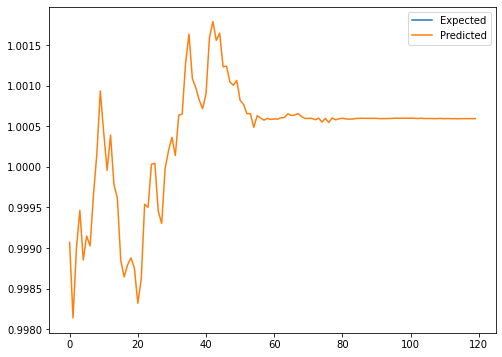

<Figure size 576x432 with 0 Axes>

In [27]:

# plot expected vs preducted
plt.plot(true_y, label='Expected')
plt.plot(pred_y, label='Predicted')
plt.legend()
plt.show()

plt.savefig(f'./xgboost_n_step{n_steps}')

___
**추가 설명**

### targetdays_predict function for loop logic example

In [184]:
temp_X = test_input.reshape(1, 6)
print(
    f'''
    first X series is {temp_X}
    current X dims is {temp_X.shape}
    '''
    )

temp_y = model.predict(temp_X)

print(
    f'''
    pred y is {temp_y}
    current y dims is {temp_y.shape}
    expanded y dims i s{np.expand_dims(temp_y, axis = 1).shape}
    '''
)

temp_X2 = np.append(temp_X, np.expand_dims(temp_y, axis = 1), axis = 1)
print(
    f'''
    temp X2 series is {temp_X2}
    current X dims is {temp_X2.shape}
    next X series is {temp_X2[:,1:]}
    next X dims is {temp_X2[:, 1:].shape}
    '''
)



    first X series is [[0.99514079 0.99029416 0.99291998 0.99465895 0.99913901 1.        ]]
    current X dims is (1, 6)
    

    pred y is [0.999557]
    current y dims is (1,)
    expanded y dims i s(1, 1)
    

    temp X2 series is [[0.99514079 0.99029416 0.99291998 0.99465895 0.99913901 1.
  0.99955702]]
    current X dims is (1, 7)
    next X series is [[0.99029416 0.99291998 0.99465895 0.99913901 1.         0.99955702]]
    next X dims is (1, 6)
    
